In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
'''%データセットのダウンロード
!pip install gdown

import gdown
file_id = "1-EyM2kIj24P6DtT-swZP8DLyBAPU1PkU"
url = f"https://drive.google.com/uc?id={file_id}"
output = "dataset.zip"
gdown.download(url, output, quiet=False)
!unzip "dataset.zip"
'''

'%データセットのダウンロード\n!pip install gdown\n\nimport gdown\nfile_id = "1-EyM2kIj24P6DtT-swZP8DLyBAPU1PkU"\nurl = f"https://drive.google.com/uc?id={file_id}"\noutput = "dataset.zip"\ngdown.download(url, output, quiet=False)\n!unzip "dataset.zip"\n'

In [2]:
#import libraries
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import numpy as np
print(torch.__version__)
torch.manual_seed(0)


1.8.1+cu101


In [3]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
LReLU_alpha = 0.2
mapping_lamda = 0.01

#https://github.com/yuuho/stylegans-pytorch/blob/master/network/stylegan2.py　を参考に
from torch.nn import functional as F
class modulated_conv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros'):
        super(modulated_conv2d, self).__init__()
        self.padding, self.stride = padding, stride

        self.weight = nn.Parameter(torch.randn(out_channels, in_channels, kernel_size, kernel_size))
        torch.nn.init.normal_(self.weight.data, mean=0.0, std=1.0)
        #self.weight = nn.Parameter(torch.zeros(out_channels, in_channels, kernel_size, kernel_size))
        self.bias = nn.Parameter(torch.zeros(1,out_channels,1,1))
        self.weight_scaler = 1 / (in_channels * kernel_size*kernel_size)**0.5

    def forward(self,x,style,shape = None,web = True,style_2 = None,mod = True):
        if not mod:
            weight = self.weight.view(1,oC,iC,kH,kW) * self.weight_scaler
            x = F.conv2d(x.view(1,N*iC,H,W), modulated_weight.view(N*oC,iC,kH,kW),
                    padding=self.padding, stride=self.stride, groups=N).view(N,oC,H,W)
            return x + self.bias

        
        oC, iC, kH, kW = self.weight.shape
        if shape is None:
            N, iC, H, W = x.shape
        else:
            N, iC, H, W = shape

        if web:
            modulated_weight = self.weight.view(1,oC,iC,kH,kW) * self.weight_scaler 
            #modulated_weight = modulated_weight.repeat(N,1,1,1,1)
            x = x * style.view(N,iC,1,1)
            x = F.conv2d(x.view(1,N*iC,H,W), modulated_weight.view(N*oC,iC,kH,kW),
                    padding=self.padding, stride=self.stride, groups=N).view(N,oC,H,W)
            modulated_weight = modulated_weight * style_2.view(N,1,iC,1,1)
            demod_norm = 1 / torch.sqrt((modulated_weight * modulated_weight).sum([2,3,4])  + 1e-8)
            out = x * demod_norm.view(N, oC, 1, 1) + self.bias   

        else:
            modulated_weight = self.weight_scaler*self.weight.view(1,oC,iC,kH,kW) * style.view(N,1,iC,1,1) 

            demod_norm = 1 / torch.sqrt((modulated_weight * modulated_weight).sum([2,3,4]) + 1e-8) # (N, oC)
            demodulated_weight = modulated_weight * demod_norm.view(N, oC, 1, 1, 1) 
            #demodulated_weight = modulated_weight
            out = F.conv2d(x.view(1,N*iC,H,W), demodulated_weight.view(N*oC,iC,kH,kW),
                    padding=self.padding, stride=self.stride, groups=N).view(N,oC,H,W) + self.bias
            
        return out

def alternative_Upsample(image,input_size):
    batches, channels, h, w = input_size

    x = image.view(batches, channels, h * w, 1)
    x = torch.cat((x,x),3)
    x = x.view(batches, channels, h, w * 2)
    x = torch.cat((x,x),3)
    x = x.view(batches, channels, h * 2, w * 2)
    return x
# Define model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        dimensions = [256,256,256,256,128,128,128,64,64,64,32,32]
        self.learning_const = torch.randn((1,dimensions[1],4,4),requires_grad=True, device = device)
        self.mapping_network = self.generate_mapping_network(dimensions[0])

        self.affine_4_0 = self.make_latent_to_style(dimensions[0],dimensions[1])
        self.block_4_0 = self.generate_block(4,dimensions[1],dimensions[2])
        self.noise_4_0 = torch.zeros((1,),requires_grad=True, device = device)
        self.affine_4_1 = self.make_latent_to_style(dimensions[0],dimensions[2])
        self.block_4_1 = self.generate_block(4,dimensions[2],dimensions[3])
        self.noise_4_1 = torch.zeros((1,),requires_grad=True, device = device)
        self.to_rgb_4 = nn.Conv2d(dimensions[3],3,kernel_size=1,stride=1,padding=0)

        self.affine_8_0 = self.make_latent_to_style(dimensions[0],dimensions[3])
        self.block_8_0 = self.generate_block(8,dimensions[3],dimensions[4],True)
        self.noise_8_0 = torch.zeros((1,),requires_grad=True, device = device)
        self.affine_8_1 = self.make_latent_to_style(dimensions[0],dimensions[4])
        self.block_8_1 = self.generate_block(8,dimensions[4],dimensions[5])
        self.noise_8_1 = torch.zeros((1,),requires_grad=True, device = device)
        self.to_rgb_8 = nn.Conv2d(dimensions[5],3,kernel_size=1,stride=1,padding=0)

        self.affine_16_0 = self.make_latent_to_style(dimensions[0],dimensions[5])
        self.block_16_0 = self.generate_block(16,dimensions[5],dimensions[6],True)
        self.noise_16_0 = torch.zeros((1,),requires_grad=True, device = device)
        self.affine_16_1 = self.make_latent_to_style(dimensions[0],dimensions[6])
        self.block_16_1 = self.generate_block(16,dimensions[6],dimensions[7])
        self.noise_16_1 = torch.zeros((1,),requires_grad=True, device = device)
        self.to_rgb_16 = nn.Conv2d(dimensions[7],3,kernel_size=1,stride=1,padding=0)

        self.affine_32_0 = self.make_latent_to_style(dimensions[0],dimensions[7])
        self.block_32_0 = self.generate_block(32,dimensions[7],dimensions[8],True)
        self.noise_32_0 = torch.zeros((1,),requires_grad=True, device = device)
        self.affine_32_1 = self.make_latent_to_style(dimensions[0],dimensions[8])
        self.block_32_1 = self.generate_block(32,dimensions[8],dimensions[9])
        self.noise_32_1 = torch.zeros((1,),requires_grad=True, device = device)
        self.to_rgb_32 = nn.Conv2d(dimensions[9],3,kernel_size=1,stride=1,padding=0)

        self.affine_64_0 = self.make_latent_to_style(dimensions[0],dimensions[9])
        self.block_64_0 = self.generate_block(64,dimensions[9],dimensions[10],True)
        self.noise_64_0 = torch.zeros((1,),requires_grad=True, device = device)
        self.affine_64_1 = self.make_latent_to_style(dimensions[0],dimensions[10])
        self.block_64_1 = self.generate_block(64,dimensions[10],dimensions[11])
        self.noise_64_1 = torch.zeros((1,),requires_grad=True, device = device)
        self.to_rgb_64 = nn.Conv2d(dimensions[11],3,kernel_size=1,stride=1,padding=0)
        for i in range(5):
            nn.init.normal_(getattr(self, 'to_rgb_{0}'.format(2 ** (i + 2))).weight, 0.0, 1.0 / getattr(self, 'to_rgb_{0}'.format(2 ** (i + 2))).weight.shape[1] ** 0.5)
            nn.init.constant_(getattr(self, 'to_rgb_{0}'.format(2 ** (i + 2))).bias, 0.0)
            
            for j in range(2):
                nn.init.normal_(getattr(self, 'affine_{0}_{1}'.format(2 ** (i + 2),j)).weight, 0.0, 1.0)
                nn.init.constant_(getattr(self, 'affine_{0}_{1}'.format(2 ** (i + 2),j)).bias, 1.0)         

    def generate_mapping_network(self,dimension = 512,number_of_layer = 1):
       mapping_network = nn.Sequential()
       for i in range(number_of_layer):
           mapping_network.add_module('mapping_fc{0}'.format(i), nn.Linear(dimension,dimension))
           mapping_network.add_module('mapping_lrelu{0}'.format(i), nn.LeakyReLU())
           nn.init.normal_(getattr(mapping_network, 'mapping_fc{0}'.format(i)).weight, 0.0, 1.0)
           nn.init.constant_(getattr(mapping_network, 'mapping_fc{0}'.format(i)).bias, 0)
       return mapping_network

    def generate_block(self,image_size = 4,in_dimension = 512, out_dimension = 512,upscaling = False):
        return modulated_conv2d(in_dimension,out_dimension,kernel_size=3,stride=1,padding=1)
        #return torch.nn.Conv2d(in_dimension,out_dimension,kernel_size=3,stride=1,padding=1)
    def make_latent_to_style(self,latent_dimension = 512, target_dimension = 512):

        return nn.Linear(latent_dimension, target_dimension)
    def forward(self, z, stage = 1 ,alpha = 0, batches = 1,web = False):
        style = self.mapping_network(z)# * mapping_lamda
        if web:
            #mapping_network_2 = self.mapping_network_2(z)
            style_2 = self.mapping_network(z)# * mapping_lamda

        x = self.learning_const.repeat(int(batches),1,1,1)
        for i in range(stage):
            if i != 0:
                if web:
                    x = alternative_Upsample(x,(1,-1,2 ** (i + 1),2 ** (i + 1)))
                else:
                    x = torch.nn.functional.interpolate(x,scale_factor=2, mode='nearest')
            for j in range(2):
                if not (i == 0 and j == 0):
                    affined_style = getattr(self, 'affine_{0}_{1}'.format(2 ** (i + 2),j))(style)
                    if web:
                        affined_style_2 = getattr(self, 'affine_{0}_{1}'.format(2 ** (i + 2),j))(style_2)
                    if web:
                        x = getattr(self, 'block_{0}_{1}'.format(2 ** (i + 2),j))(x,affined_style,shape = (1,-1,2 ** (i + 2),2 ** (i + 2)),style_2 = affined_style_2,web = True)
                    else:
                        x = getattr(self, 'block_{0}_{1}'.format(2 ** (i + 2),j))(x,affined_style,web = False)
                    x = F.leaky_relu(x,LReLU_alpha)
                    #x = x + torch.randn(x.shape, device = device) *  getattr(self, 'noise_{0}_{1}'.format(2 ** (i + 2),j))

        x_out = getattr(self, 'to_rgb_{0}'.format(2 ** (stage + 1)))(x)

        if alpha != 0:
            if web:
                x = alternative_Upsample(x,(1,-1,2 ** (stage + 1),2 ** (stage + 1)))
            else:
                x = torch.nn.functional.interpolate(x,scale_factor=2, mode='nearest')
            for j in range(2):
                affined_style = getattr(self, 'affine_{0}_{1}'.format(2 ** (stage + 2),j))(style)
                if web:
                    affined_style_2 = getattr(self, 'affine_{0}_{1}'.format(2 ** (stage + 2),j))(style_2)
                if web:
                    x = getattr(self, 'block_{0}_{1}'.format(2 ** (stage + 2),j))(x,affined_style,shape = (1,-1,2 ** (i + 2),2 ** (i + 2)),style_2 = affined_style_2,web = True)
                else:
                    x = getattr(self, 'block_{0}_{1}'.format(2 ** (stage + 2),j))(x,affined_style,web =False)
                
                x = F.leaky_relu(x,LReLU_alpha)
                #x = x + torch.randn(x.shape, device = device) * getattr(self, 'noise_{0}_{1}'.format(2 ** (i + 2),j))
            x = getattr(self, 'to_rgb_{0}'.format(2 ** (stage + 2)))(x)
            if web:
                x_out = alpha * x + alternative_Upsample(x_out,(1,-1,2 ** (stage + 1),2 ** (stage + 1))) * (1 - alpha)
            else:
                x_out = alpha * x + torch.nn.functional.interpolate(x_out,scale_factor=2, mode='nearest') * (1 - alpha)
            
        return x_out

Using cuda device


In [4]:
# Define model
from torch.autograd import Variable
from torch import autograd
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        dimensions = [256,256,256,128,128,128,64,64,64,32,32,32]

        self.from_rgb_4 = nn.Conv2d(3,dimensions[2],kernel_size=1,stride=1,padding=0)
        self.block_4_0 = self.generate_block(4,dimensions[2],dimensions[1])
        self.block_4_1 = self.generate_block(4,dimensions[1],dimensions[0])

        self.from_rgb_8 = nn.Conv2d(3,dimensions[4],kernel_size=1,stride=1,padding=0)
        self.block_8_0 = self.generate_block(8,dimensions[4],dimensions[3])
        self.block_8_1 = self.generate_block(8,dimensions[3],dimensions[2])

        self.from_rgb_16 = nn.Conv2d(3,dimensions[6],kernel_size=1,stride=1,padding=0)
        self.block_16_0 = self.generate_block(16,dimensions[6],dimensions[5])
        self.block_16_1 = self.generate_block(16,dimensions[5],dimensions[4])

        self.from_rgb_32 = nn.Conv2d(3,dimensions[8],kernel_size=1,stride=1,padding=0)
        self.block_32_0 = self.generate_block(32,dimensions[8],dimensions[7])
        self.block_32_1 = self.generate_block(32,dimensions[7],dimensions[6])

        self.from_rgb_64 = nn.Conv2d(3,dimensions[10],kernel_size=1,stride=1,padding=0)
        self.block_64_0 = self.generate_block(64,dimensions[10],dimensions[9])
        self.block_64_1 = self.generate_block(64,dimensions[9],dimensions[8])

        self.final_conv = nn.Conv2d(dimensions[0],dimensions[0],kernel_size=4,stride=1,padding=0)
        self.linear = nn.Linear(dimensions[0],1)
        nn.init.normal_(self.final_conv.weight, 0.0, 1.0 / (4*4**dimensions[0]) ** 0.5)
        nn.init.constant_(self.final_conv.bias, 0)
        nn.init.normal_(self.linear.weight, 0.0, 1.0)
        nn.init.constant_(self.linear.bias, 0)
        for i in range(5):
            nn.init.normal_(getattr(self, 'from_rgb_{0}'.format(2 ** (i + 2))).weight, 0.0, 1.0 / getattr(self, 'from_rgb_{0}'.format(2 ** (i + 2))).weight.shape[1] ** 0.5)
            nn.init.constant_(getattr(self, 'from_rgb_{0}'.format(2 ** (i + 2))).bias, 0.0)

    def generate_block(self,image_size = 4,in_dimension = 512, out_dimension = 512):
        block = nn.Sequential()

        block.add_module('Conv', nn.Conv2d(in_dimension,out_dimension,kernel_size=3,stride=1,padding=1))
        block.add_module('relu', nn.LeakyReLU(LReLU_alpha))
        nn.init.normal_(block.Conv.weight, 0.0, 1.0)
        nn.init.constant_(block.Conv.bias, 0)

        return block
    #https://github.com/Zeleni9/pytorch-wgan/blob/master/models/wgan_gradient_penalty.py を改変
    def calculate_gradient_penalty(self, real_images, fake_images,batch_size,stage,alpha):
        eta = torch.FloatTensor(batch_size,1,1,1).uniform_(0,1).to(device)
        eta = eta.expand(batch_size, real_images.size(1), real_images.size(2), real_images.size(3))

        interpolated = eta * real_images + ((1 - eta) * fake_images)

        # define it to calculate gradient
        interpolated = Variable(interpolated, requires_grad=True)
        # calculate probability of interpolated examples
        prob_interpolated = self(interpolated,stage,alpha)
        # calculate gradients of probabilities with respect to examples
        gradients = autograd.grad(outputs=prob_interpolated, inputs=interpolated,
                              grad_outputs=torch.ones(
                                  prob_interpolated.size()).to(device),
                              create_graph=True, retain_graph=True)[0]
        grad_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        return grad_penalty
    
    def forward(self, image, stage = 1 ,alpha = 0, batches = 1):
        if alpha != 0:
            x = getattr(self, 'from_rgb_{0}'.format(2 ** (stage + 2)))(image)
            x = nn.LeakyReLU(LReLU_alpha)(x)
            for j in range(2):
                x = getattr(self, 'block_{0}_{1}'.format(2 ** (stage + 2),j))(x)
            x = torch.nn.functional.interpolate(x,scale_factor=0.5, mode='nearest')
            x2 = getattr(self, 'from_rgb_{0}'.format(2 ** (stage + 1)))(torch.nn.functional.interpolate(image,scale_factor=0.5, mode='nearest'))
            x2 = nn.LeakyReLU(LReLU_alpha)(x2)
            x = x * alpha + x2 * (1 - alpha)
        else:
            x = getattr(self, 'from_rgb_{0}'.format(2 ** (stage + 1)))(image)
            x = nn.LeakyReLU(LReLU_alpha)(x)

        for i in range(stage):
            for j in range(2):
                if not (i == stage - 1 and j == 1):
                    x = getattr(self, 'block_{0}_{1}'.format(2 ** (stage + 1 - i),j))(x)
            if i != stage - 1:
                x = torch.nn.functional.interpolate(x,scale_factor=0.5, mode='nearest')

        x = self.final_conv(x)
        
        x = nn.LeakyReLU(LReLU_alpha)(x)
        x = nn.Flatten()(x)
        return  self.linear(x)

In [5]:
class trainer():
    def __init__(self,learning_rate = 0.0002):
        self.alpha = 0
        self.stage = 0
        self.MAX_STAGE = 4
        self.BATCH_SIZE = 32
        self.n_critic = 1
        self.gp_lamda = 1
        self.g = Generator().to(device)
        self.d = Discriminator().to(device)
        self.G_optimizer = torch.optim.Adam(self.g.parameters(), lr=learning_rate)
        self.D_optimizer = torch.optim.Adam(self.d.parameters(), lr=learning_rate)
        self.NUM_EPOCH_NO_ALPHA = 10
        self.NUM_EPOCH_WITH_ALPHA = 10
        self.z_dimension = 256
    def train(self):
        MAX_STAGE = self.MAX_STAGE
        BATCH_SIZE = self.BATCH_SIZE
        n_critic = self.n_critic
        gp_lamda = self.gp_lamda
        g = self.g
        d = self.d
        G_optimizer = self.G_optimizer
        D_optimizer = self.D_optimizer
        NUM_EPOCH_NO_ALPHA = self.NUM_EPOCH_NO_ALPHA
        NUM_EPOCH_WITH_ALPHA = self.NUM_EPOCH_WITH_ALPHA
        z_dimension = self.z_dimension
        training_data = datasets.CIFAR10(
            root="data",
            train=True,
            download=True,
            transform=ToTensor(),
        )
        train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
        while True:
            for epoch in range(NUM_EPOCH_NO_ALPHA + NUM_EPOCH_WITH_ALPHA):
                number_of_batch = 0
                for X, _ in train_dataloader:
                    X = X * 2 - 1
                    
                    alpha = 0
                    if int(self.stage) % 2 == 1:
                        self.stage += 1 / (len(train_dataloader) * NUM_EPOCH_WITH_ALPHA) 
                    elif math.ceil(self.stage / 2) < self.MAX_STAGE:
                        self.stage += 1 / (len(train_dataloader) * NUM_EPOCH_NO_ALPHA)
                    stage = math.ceil(self.stage / 2)    
                    if int(self.stage) % 2 == 1:
                        alpha = self.stage - int(self.stage)
                    
                    for _ in range(n_critic):
                        z = torch.randn((BATCH_SIZE,z_dimension),device = device)
                        generated = g(z, stage = stage ,alpha = alpha, batches = BATCH_SIZE)
                        X = X.to(device)
                        X = torch.nn.functional.interpolate(X,size=generated.size(2), mode='nearest')
                        y_real = d(X, stage = stage ,alpha = alpha, batches = BATCH_SIZE)
                        y_fake = d(generated, stage = stage ,alpha = alpha, batches = BATCH_SIZE)
                        d_loss = torch.mean(y_fake) - torch.mean(y_real) + d.calculate_gradient_penalty(X,generated,BATCH_SIZE,stage,alpha) * gp_lamda
                        Wasserstein_loss =  (torch.mean(y_fake) - torch.mean(y_real)).data

                        D_optimizer.zero_grad()
                        d_loss.backward()
                        D_optimizer.step()
                    g_loss = 'undefined'
                    if Wasserstein_loss <= 0:
                        z = torch.randn((BATCH_SIZE,z_dimension),device = device)
                        generated = g(z, stage = stage ,alpha = alpha, batches = BATCH_SIZE)
                        y_fake = d(generated, stage = stage ,alpha = alpha, batches = BATCH_SIZE)
                        g_loss = -torch.mean(y_fake)
                        G_optimizer.zero_grad()
                        g_loss.backward()
                        G_optimizer.step()

                    

                    if number_of_batch % 100 == 0:
                        print('epoch:{}, batch:{},stage:{},alpha{},g_loss:{}, d_loss:{}, Wasserstein Loss:{}'.format(epoch,number_of_batch,stage,alpha,g_loss,d_loss,Wasserstein_loss))
                        show_image(generated)
                        show_image(X)
                        torch.save(self, '/content/drive/MyDrive/StyleGAN2/model.pth')
                    number_of_batch += 1

In [8]:
#util for training
from IPython.display import Image,display_png
from PIL import Image
import math

def combine_images(generated_images):
    total = generated_images.shape[0]
    cols = int(math.sqrt(total))
    rows = math.ceil(float(total)/cols)
    width, height = generated_images.shape[1:3]
    combined_image = np.zeros((width*cols, height*rows,3),
                              dtype=generated_images.dtype)
    #coreturn combined_image

    for index, image in enumerate(generated_images):
        i = index % cols
        j = int(index/cols)
        combined_image[width*i:width*(i+1), height*j:height*(j+1),0:3] = image[:,:,0:3 ]
    return combined_image

def show_image(result):
    generated_image = result.to('cpu').detach().numpy().copy()
    generated_image = generated_image * 127.5 + 127.5
    generated_image = np.where(generated_image < 0, 0, generated_image)
    generated_image = np.where(generated_image > 255, 255, generated_image)
    generated_image=np.transpose(generated_image, (0, 2, 3, 1))
    generated_image = combine_images(generated_image)
    generated_image = generated_image.astype(np.uint8)
    image = Image.fromarray(generated_image)
    display_png(image)

Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3503: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


epoch:0, batch:0,stage:3,alpha0,g_loss:74112.703125, d_loss:-140.53814697265625, Wasserstein Loss:-413.7421875


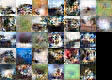

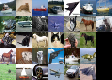

epoch:0, batch:100,stage:3,alpha0,g_loss:89324.984375, d_loss:-27.75030517578125, Wasserstein Loss:-312.5390625


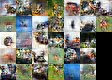

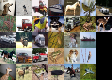

epoch:0, batch:200,stage:3,alpha0,g_loss:74261.53125, d_loss:-102.6956787109375, Wasserstein Loss:-348.609375


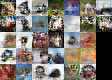

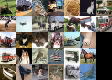

epoch:0, batch:300,stage:3,alpha0,g_loss:87486.4375, d_loss:-115.34774780273438, Wasserstein Loss:-410.2421875


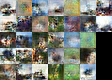

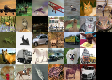

epoch:0, batch:400,stage:3,alpha0,g_loss:65692.4375, d_loss:-222.95794677734375, Wasserstein Loss:-504.828125


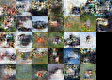

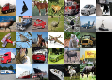

epoch:0, batch:500,stage:3,alpha0,g_loss:21238.712890625, d_loss:-131.45960998535156, Wasserstein Loss:-353.662109375


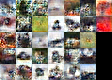

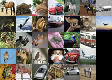

epoch:0, batch:600,stage:3,alpha0,g_loss:43645.7578125, d_loss:26.19879150390625, Wasserstein Loss:-171.296875


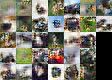

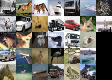

epoch:0, batch:700,stage:3,alpha0,g_loss:50351.1953125, d_loss:50.72296142578125, Wasserstein Loss:-360.046875


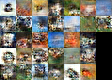

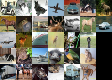

epoch:0, batch:800,stage:3,alpha0,g_loss:89822.46875, d_loss:-89.86276245117188, Wasserstein Loss:-336.7578125


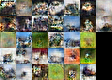

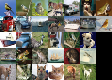

epoch:0, batch:900,stage:3,alpha0,g_loss:50427.8515625, d_loss:-169.33644104003906, Wasserstein Loss:-382.8828125


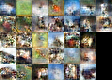

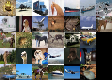

epoch:0, batch:1000,stage:3,alpha0,g_loss:1425.343505859375, d_loss:118.40045166015625, Wasserstein Loss:-216.0458984375


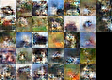

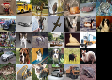

epoch:0, batch:1100,stage:3,alpha0,g_loss:80572.125, d_loss:98.90687561035156, Wasserstein Loss:-123.640625


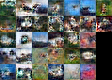

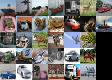

epoch:0, batch:1200,stage:3,alpha0,g_loss:91583.8828125, d_loss:-72.07192993164062, Wasserstein Loss:-249.578125


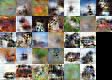

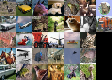

epoch:0, batch:1300,stage:3,alpha0,g_loss:81963.921875, d_loss:-144.54721069335938, Wasserstein Loss:-338.90625


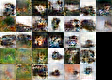

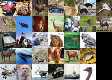

epoch:0, batch:1400,stage:3,alpha0,g_loss:109177.6875, d_loss:21.700225830078125, Wasserstein Loss:-293.6484375


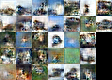

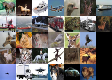

epoch:0, batch:1500,stage:3,alpha0,g_loss:46922.48828125, d_loss:16.542022705078125, Wasserstein Loss:-120.4453125


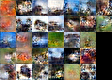

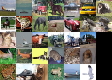

epoch:1, batch:0,stage:3,alpha0,g_loss:undefined, d_loss:288.4631652832031, Wasserstein Loss:45.609375


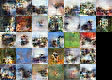

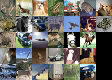

epoch:1, batch:100,stage:3,alpha0,g_loss:81974.34375, d_loss:-115.71090698242188, Wasserstein Loss:-355.390625


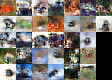

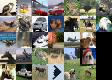

epoch:1, batch:200,stage:3,alpha0,g_loss:undefined, d_loss:943.703369140625, Wasserstein Loss:35.15625


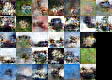

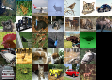

epoch:1, batch:300,stage:3,alpha0,g_loss:861.546630859375, d_loss:-263.3541259765625, Wasserstein Loss:-591.32421875


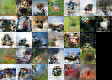

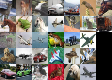

epoch:1, batch:400,stage:3,alpha0,g_loss:117255.1875, d_loss:62.152618408203125, Wasserstein Loss:-184.25


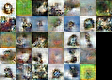

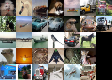

epoch:1, batch:500,stage:3,alpha0,g_loss:82476.453125, d_loss:-37.4931640625, Wasserstein Loss:-306.796875


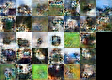

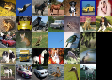

epoch:1, batch:600,stage:3,alpha0,g_loss:89234.0, d_loss:92.66522216796875, Wasserstein Loss:-192.609375


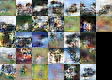

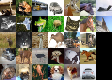

epoch:1, batch:700,stage:3,alpha0,g_loss:30229.541015625, d_loss:27.226531982421875, Wasserstein Loss:-179.94140625


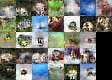

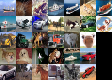

epoch:1, batch:800,stage:3,alpha0,g_loss:90735.3203125, d_loss:-271.8934326171875, Wasserstein Loss:-576.1328125


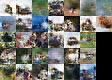

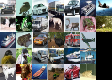

epoch:1, batch:900,stage:3,alpha0,g_loss:46723.7109375, d_loss:47.26188659667969, Wasserstein Loss:-93.80859375


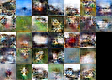

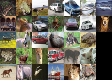

epoch:1, batch:1000,stage:3,alpha0,g_loss:80198.15625, d_loss:-10.18426513671875, Wasserstein Loss:-240.9765625


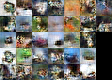

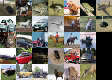

epoch:1, batch:1100,stage:3,alpha0,g_loss:33233.859375, d_loss:-3.7877044677734375, Wasserstein Loss:-176.28125


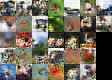

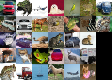

epoch:1, batch:1200,stage:3,alpha0,g_loss:89789.0703125, d_loss:12.991989135742188, Wasserstein Loss:-213.0


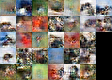

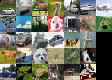

epoch:1, batch:1300,stage:3,alpha0,g_loss:85159.734375, d_loss:44.73100280761719, Wasserstein Loss:-134.9375


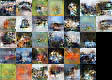

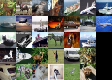

epoch:1, batch:1400,stage:3,alpha0,g_loss:121904.0703125, d_loss:-78.22463989257812, Wasserstein Loss:-305.390625


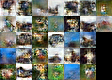

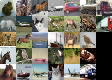

epoch:1, batch:1500,stage:3,alpha0,g_loss:64316.3125, d_loss:-143.3187255859375, Wasserstein Loss:-467.28125


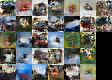

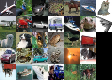

epoch:2, batch:0,stage:3,alpha0,g_loss:68998.0078125, d_loss:140.55776977539062, Wasserstein Loss:-118.08203125


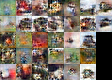

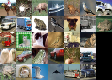

epoch:2, batch:100,stage:3,alpha0,g_loss:undefined, d_loss:170.83351135253906, Wasserstein Loss:11.84375


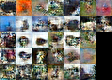

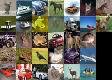

epoch:2, batch:200,stage:3,alpha0,g_loss:52592.9296875, d_loss:87.09988403320312, Wasserstein Loss:-81.625


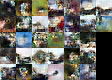

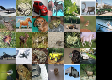

epoch:2, batch:300,stage:3,alpha0,g_loss:112805.3984375, d_loss:10.792205810546875, Wasserstein Loss:-230.46875


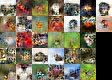

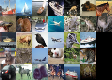

epoch:2, batch:400,stage:3,alpha0,g_loss:-14757.921875, d_loss:246.49899291992188, Wasserstein Loss:-106.5263671875


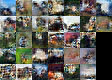

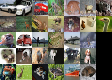

epoch:2, batch:500,stage:3,alpha0,g_loss:67304.6953125, d_loss:31.976516723632812, Wasserstein Loss:-125.984375


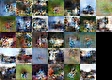

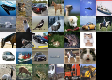

epoch:2, batch:600,stage:3,alpha0,g_loss:103554.5625, d_loss:-133.19717407226562, Wasserstein Loss:-320.1875


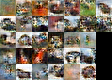

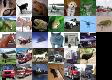

epoch:2, batch:700,stage:3,alpha0,g_loss:undefined, d_loss:191.60476684570312, Wasserstein Loss:15.94140625


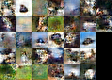

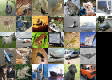

epoch:2, batch:800,stage:3,alpha0,g_loss:43322.0546875, d_loss:-26.554306030273438, Wasserstein Loss:-179.90234375


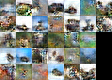

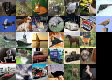

epoch:2, batch:900,stage:3,alpha0,g_loss:84488.09375, d_loss:-96.48556518554688, Wasserstein Loss:-280.265625


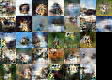

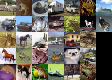

epoch:2, batch:1000,stage:3,alpha0,g_loss:undefined, d_loss:333.1757507324219, Wasserstein Loss:134.71875


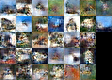

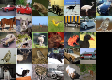

epoch:2, batch:1100,stage:3,alpha0,g_loss:42035.7890625, d_loss:-114.84866333007812, Wasserstein Loss:-261.859375


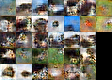

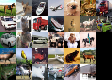

epoch:2, batch:1200,stage:3,alpha0,g_loss:95418.1171875, d_loss:149.927734375, Wasserstein Loss:-269.5


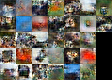

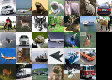

epoch:2, batch:1300,stage:3,alpha0,g_loss:64216.60546875, d_loss:61.115081787109375, Wasserstein Loss:-110.53125


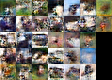

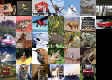

epoch:2, batch:1400,stage:3,alpha0,g_loss:65483.0234375, d_loss:-101.11759948730469, Wasserstein Loss:-288.15625


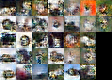

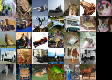

epoch:2, batch:1500,stage:3,alpha0,g_loss:61210.953125, d_loss:-18.4466552734375, Wasserstein Loss:-247.81640625


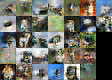

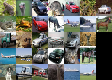

epoch:3, batch:0,stage:3,alpha0,g_loss:63026.1484375, d_loss:24.24713134765625, Wasserstein Loss:-194.234375


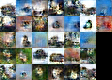

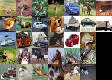

epoch:3, batch:100,stage:3,alpha0,g_loss:87723.28125, d_loss:-107.43359375, Wasserstein Loss:-312.1640625


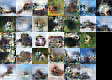

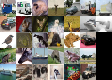

epoch:3, batch:200,stage:3,alpha0,g_loss:70446.109375, d_loss:121.46742248535156, Wasserstein Loss:-66.28125


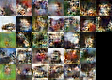

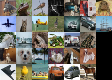

epoch:3, batch:300,stage:3,alpha0,g_loss:62616.984375, d_loss:-6.926788330078125, Wasserstein Loss:-180.51171875


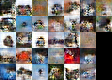

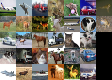

epoch:3, batch:400,stage:3,alpha0,g_loss:65034.77734375, d_loss:190.57537841796875, Wasserstein Loss:-104.9765625


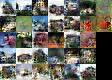

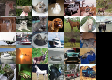

epoch:3, batch:500,stage:3,alpha0,g_loss:85623.6484375, d_loss:-45.417999267578125, Wasserstein Loss:-268.421875


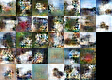

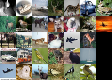

epoch:3, batch:600,stage:3,alpha0,g_loss:94281.59375, d_loss:-213.92059326171875, Wasserstein Loss:-453.53125


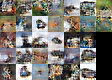

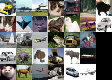

epoch:3, batch:700,stage:3,alpha0,g_loss:92157.8515625, d_loss:-45.30665588378906, Wasserstein Loss:-229.84375


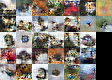

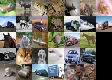

epoch:3, batch:800,stage:3,alpha0,g_loss:71768.34375, d_loss:12.053558349609375, Wasserstein Loss:-164.1328125


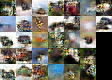

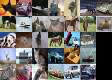

epoch:3, batch:900,stage:3,alpha0,g_loss:90785.5234375, d_loss:-29.262619018554688, Wasserstein Loss:-198.296875


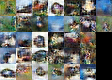

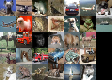

epoch:3, batch:1000,stage:3,alpha0,g_loss:44813.8125, d_loss:-174.16937255859375, Wasserstein Loss:-567.7109375


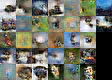

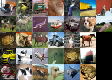

epoch:3, batch:1100,stage:3,alpha0,g_loss:96368.65625, d_loss:-22.586212158203125, Wasserstein Loss:-239.828125


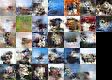

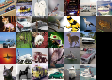

epoch:3, batch:1200,stage:3,alpha0,g_loss:81342.96875, d_loss:-29.942474365234375, Wasserstein Loss:-345.7265625


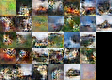

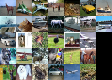

epoch:3, batch:1300,stage:3,alpha0,g_loss:58034.59375, d_loss:-27.175125122070312, Wasserstein Loss:-221.1953125


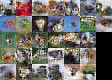

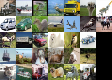

epoch:3, batch:1400,stage:3,alpha0,g_loss:45986.765625, d_loss:-121.0196533203125, Wasserstein Loss:-272.875


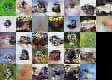

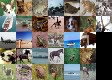

epoch:3, batch:1500,stage:3,alpha0,g_loss:90547.59375, d_loss:-1.22674560546875, Wasserstein Loss:-312.3828125


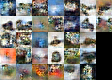

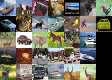

epoch:4, batch:0,stage:3,alpha0,g_loss:40230.734375, d_loss:-137.30291748046875, Wasserstein Loss:-381.80078125


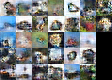

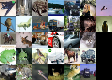

epoch:4, batch:100,stage:3,alpha0,g_loss:75559.46875, d_loss:-37.579742431640625, Wasserstein Loss:-233.4765625


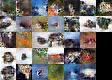

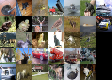

epoch:4, batch:200,stage:3,alpha0,g_loss:87872.21875, d_loss:-111.07034301757812, Wasserstein Loss:-317.84375


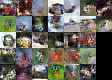

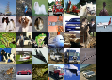

epoch:4, batch:300,stage:3,alpha0,g_loss:68289.09375, d_loss:-194.39779663085938, Wasserstein Loss:-390.3046875


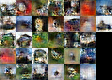

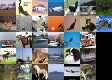

epoch:4, batch:400,stage:3,alpha0,g_loss:74460.796875, d_loss:130.85177612304688, Wasserstein Loss:-73.359375


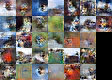

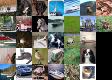

epoch:4, batch:500,stage:3,alpha0,g_loss:59080.3671875, d_loss:-35.454681396484375, Wasserstein Loss:-199.609375


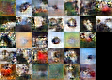

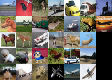

epoch:4, batch:600,stage:3,alpha0,g_loss:71435.265625, d_loss:-44.583984375, Wasserstein Loss:-219.921875


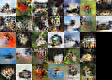

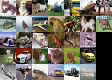

epoch:4, batch:700,stage:3,alpha0,g_loss:103220.515625, d_loss:-68.23056030273438, Wasserstein Loss:-267.234375


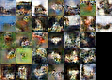

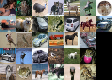

epoch:4, batch:800,stage:3,alpha0,g_loss:91213.859375, d_loss:-21.160659790039062, Wasserstein Loss:-202.7109375


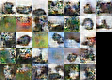

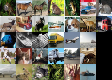

epoch:4, batch:900,stage:3,alpha0,g_loss:111665.3125, d_loss:-137.28970336914062, Wasserstein Loss:-369.046875


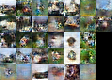

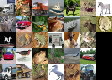

epoch:4, batch:1000,stage:3,alpha0,g_loss:61203.31640625, d_loss:14.034027099609375, Wasserstein Loss:-188.890625


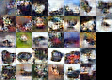

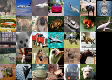

epoch:4, batch:1100,stage:3,alpha0,g_loss:91600.6171875, d_loss:-102.87774658203125, Wasserstein Loss:-351.375


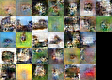

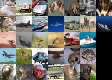

epoch:4, batch:1200,stage:3,alpha0,g_loss:113104.5078125, d_loss:-51.40814208984375, Wasserstein Loss:-259.5703125


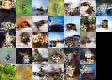

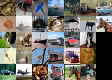

epoch:4, batch:1300,stage:3,alpha0,g_loss:94309.46875, d_loss:210.16998291015625, Wasserstein Loss:-105.28125


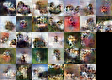

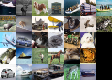

epoch:4, batch:1400,stage:3,alpha0,g_loss:101745.3125, d_loss:-21.003570556640625, Wasserstein Loss:-251.265625


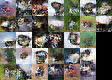

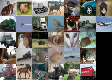

epoch:4, batch:1500,stage:3,alpha0,g_loss:57179.16796875, d_loss:21.08843994140625, Wasserstein Loss:-110.43359375


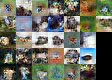

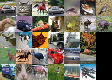

epoch:5, batch:0,stage:3,alpha0,g_loss:88118.6796875, d_loss:-51.0401611328125, Wasserstein Loss:-254.8046875


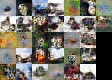

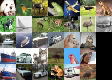

epoch:5, batch:100,stage:3,alpha0,g_loss:54912.7109375, d_loss:-25.32501220703125, Wasserstein Loss:-225.14453125


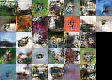

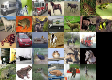

epoch:5, batch:200,stage:3,alpha0,g_loss:53266.171875, d_loss:-234.84735107421875, Wasserstein Loss:-445.84765625


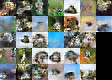

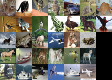

epoch:5, batch:300,stage:3,alpha0,g_loss:29982.71875, d_loss:-43.029296875, Wasserstein Loss:-204.759765625


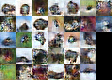

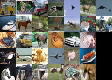

epoch:5, batch:400,stage:3,alpha0,g_loss:54190.65625, d_loss:-224.21273803710938, Wasserstein Loss:-476.1171875


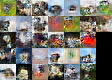

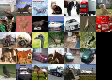

epoch:5, batch:500,stage:3,alpha0,g_loss:25382.109375, d_loss:-50.222991943359375, Wasserstein Loss:-290.5703125


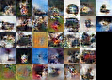

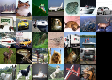

epoch:5, batch:600,stage:3,alpha0,g_loss:64977.6484375, d_loss:1.999664306640625, Wasserstein Loss:-170.1015625


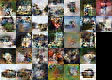

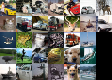

epoch:5, batch:700,stage:3,alpha0,g_loss:78599.71875, d_loss:-228.22134399414062, Wasserstein Loss:-433.109375


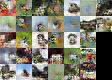

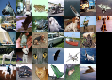

epoch:5, batch:800,stage:3,alpha0,g_loss:-4358.408203125, d_loss:-25.734649658203125, Wasserstein Loss:-296.53515625


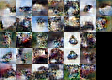

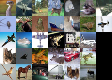

epoch:5, batch:900,stage:3,alpha0,g_loss:80211.625, d_loss:161.43955993652344, Wasserstein Loss:-50.1640625


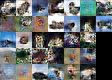

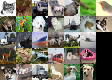

epoch:5, batch:1000,stage:3,alpha0,g_loss:undefined, d_loss:608.9664916992188, Wasserstein Loss:355.4140625


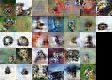

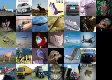

epoch:5, batch:1100,stage:3,alpha0,g_loss:66641.90625, d_loss:-39.160308837890625, Wasserstein Loss:-259.828125


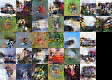

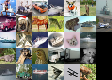

epoch:5, batch:1200,stage:3,alpha0,g_loss:72238.9765625, d_loss:-172.1981964111328, Wasserstein Loss:-325.4140625


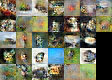

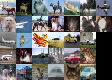

epoch:5, batch:1300,stage:3,alpha0,g_loss:77364.28125, d_loss:-30.374069213867188, Wasserstein Loss:-187.40625


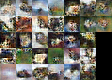

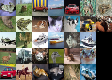

epoch:5, batch:1400,stage:3,alpha0,g_loss:70836.2890625, d_loss:-578.6856689453125, Wasserstein Loss:-791.37890625


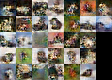

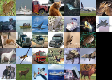

epoch:5, batch:1500,stage:3,alpha0,g_loss:56871.7734375, d_loss:-31.414756774902344, Wasserstein Loss:-155.23828125


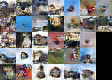

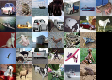

epoch:6, batch:0,stage:3,alpha0,g_loss:63141.1796875, d_loss:-36.844749450683594, Wasserstein Loss:-153.1328125


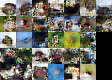

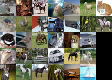

epoch:6, batch:100,stage:3,alpha0,g_loss:98293.5625, d_loss:92.89234924316406, Wasserstein Loss:-122.078125


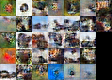

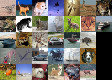

epoch:6, batch:200,stage:3,alpha0,g_loss:63686.8203125, d_loss:127.76045227050781, Wasserstein Loss:-124.25


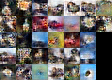

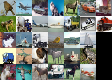

In [ ]:
try:
    train = torch.load('/content/drive/MyDrive/StyleGAN2/model.pth')
except:
    train = trainer()

train.train()

In [6]:
#make ONNX model
try:
    train = torch.load('/content/drive/MyDrive/StyleGAN2/model.pth')
except:
    train = trainer()
    print('load failed')

dummy_input = torch.randn(1, train.z_dimension, device=device)
train.g.learning_const.requires_grad = False
for i in range(5):  
    for j in range(2):
        getattr(train.g, 'noise_{0}_{1}'.format(2 ** (i + 2),j)).requires_grad = False
        getattr(train.g, 'noise_{0}_{1}'.format(2 ** (i + 2),j)).requires_grad = False
stage = torch.tensor(3, dtype=torch.int)
alpha = torch.tensor(0, dtype=torch.int)
batches = torch.tensor(1, dtype=torch.int)
web = torch.tensor(True, dtype=torch.bool)
torch.onnx.export(train.g, (dummy_input,stage,alpha,batches,web), 'generator.onnx', opset_version= 9)

from google.colab import files
files.download('generator.onnx')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:133: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:143: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
/usr/lo

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
'''
#testing
#train = torch.load('/content/drive/MyDrive/StyleGAN2/model.pth')
train = trainer()
z = torch.zeros(1, train.z_dimension, device=device)
train.g(z,web=True)
'''